# Global Warming

Study made in October 2019.

First, we have to define some utility routines

In [1]:
# Needed Julia packages:
#   DelimitedFiles: for readdlm() needed for importing data
#   Statistics: for mean()
#   FFTW: for fft()
#   DSP: for fftfreq()
#   Plots: for drawing data with plot()
using DelimitedFiles, Statistics, FFTW, DSP, Plots

In [2]:
# Find the first max value and the index from an array
# Note: Quick & dirty algorithm: the array need to be filtered
# and we suppose a maximum is found within the range [s:e].
function findOptimum(A::Array{Float64}, s::Int64, e::Int64)
    i = s
    while (i < e) && (A[i] < A[i + 1]) 
        i = i + 1
    end
    return i, A[i]
end

findOptimum (generic function with 1 method)

In [3]:
# Linear regression
linreg(x, y) = hcat(fill!(similar(x), 1), x) \ y

# Constrain x between low and high
constrain(x, low, high) = (x < low) ? low : (x > high ? high : x)

# Convert a year to array index and constrain it inside the array range
y2i(A::Array, y::Int64) = constrain(1 + y - Int64(A[1]), 1, length(A))

y2i (generic function with 1 method)

In [4]:
# Filter function based on FFT
# r: range of frequencies we want to preserve:
#   preserve low +ve frequencies [1:r+1]
#   preserve low -ve frequencies [end-r+1:end]
# Unpreserved frequencies are zero'ed.
function filtFFT(S::Vector{Float64}, r::Int64)
    F = fft(S)
    F[r+1:end-r+1] .= 0.0
    real(ifft(F))
end

filtFFT (generic function with 1 method)

## HadCRUT4's temperature anomalies

In [5]:
# HadCRUT4: matrix year-month of temperature anomalies since 1850
#  1st column = year
#  other colum = 12 temperature (one by month)
H = convert(Matrix{Float64}, readdlm("data/HadCRUT4.txt", ' ', Any, '\n'))

# Dh: years, Th: averaged temperature over each year. h: HadCRUT4
Dh, Th = convert(Vector{Int64}, H[:,1]), mean(H[:,2:end]; dims=2)[:]

# Convert HadCRUT4 year to HadCRUT4 index
yh2i(y::Int64) = y2i(Dh, y)

yh2i (generic function with 1 method)

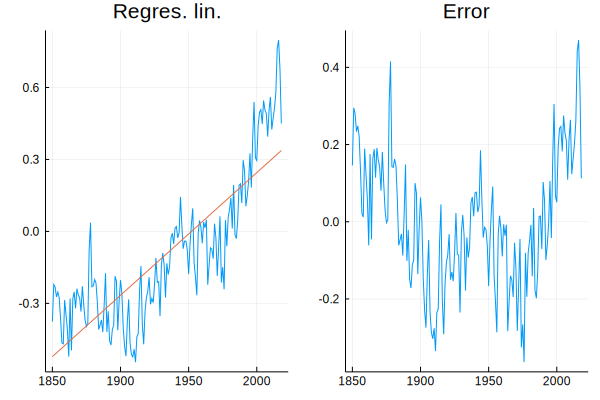

In [6]:
# Get the linear regression of temperatures over years
b, a = linreg(Dh, Th)
regTh = a .* Dh .+ b

plot(plot(Dh, [Th regTh], title="Regres. lin.", leg=false),
     plot(Dh, Th .- regTh, title="Error", leg=false),
     layout=2)

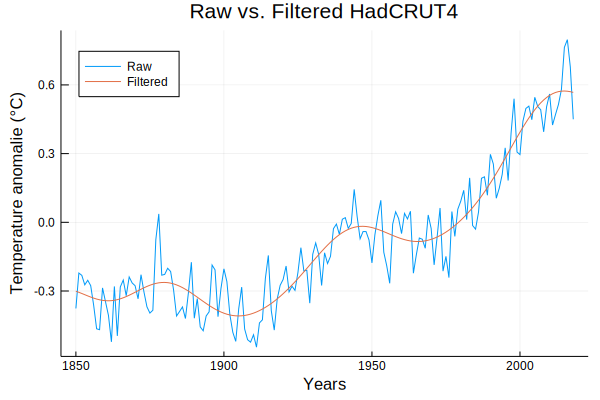

In [7]:
# Filter the raw signal minus its linear regression. Thf: HadCRUT4 filtered temperature.
Thf = filtFFT(Th .- regTh, 6) .+ regTh

plot(Dh, [Th Thf], title = "Raw vs. Filtered HadCRUT4",
                   xlabel="Years", ylabel="Temperature anomalie (°C)", 
                   label=["Raw" "Filtered"], legend=:topleft)

Note the peak at 2015 -- 2016 implied by El Niño.

We notice 3 cycles where the temperature is optimum since year 1850:
- 1st cycle at around year 1880
- 2nd cycle at around year 1950
- 3th cycle at around year 2016

In [8]:
y1, Rc1 = findOptimum(Thf, yh2i(1870), yh2i(1890))
y2, Rc2 = findOptimum(Thf, yh2i(1940), yh2i(1955))
y3, Rc3 = findOptimum(Thf, yh2i(2000), yh2i(Dh[end]))

[Dh[y1] Dh[y2] Dh[y3]], [Rc1 Rc2 Rc3]

([1880 1947 2015], [-0.262559 -0.0174584 0.57336])

These cycles seem to be periodic:

In [9]:
y2 - y1, y3 - y2, "years"

(67, 68, "years")

Estimated next optimum cycle:

In [10]:
y3 + (y2 - y1 + y3 - y2) ÷ 2

2085

## Estimated temperature based on filtered HadCRUT4 values

Let suppose a new cycle will apear on years 2090 and where the ratio of the amplitude between the third cycle (year 2016) and the second cycle (year 1950) is the same than the second cycle and the first (year 1880). This supposition comes from:
- the human kind economy will keep increasing with the same current **exponential** rate;
- the temperature raise is mainly due by the human kind;

We can estimate the temperature (°C) for 2090:

In [11]:
Rc32 = Rc3 - Rc2
Rc21 = Rc2 - Rc1
EstimTh = Rc32 * (Rc32 / Rc21)

1.424176423062246

## GIEC's AR5 Model

In [12]:
G = convert(Matrix{Float64}, readdlm("data/AR5.txt", ' ', Any, '\n'));

# We halt the GIEC's model to Year 2020 because after the model is purely linear
Dend = Int64(2020 - G[1,1])

# D: years, T: temperature. g: GIEC
Dg, Tg = G[1:Dend,1], G[1:Dend,2]

# Convert GIEC year to GIEC index
yg2i(y::Int64) = y2i(Dg, y)

# Offset between GIEC value and HadCRUT4
Toff = mean(Th[yh2i(1980):yh2i(2010)]) - mean(Tg[yg2i(1980):yg2i(2010)])
Tg = Tg .+ Toff;

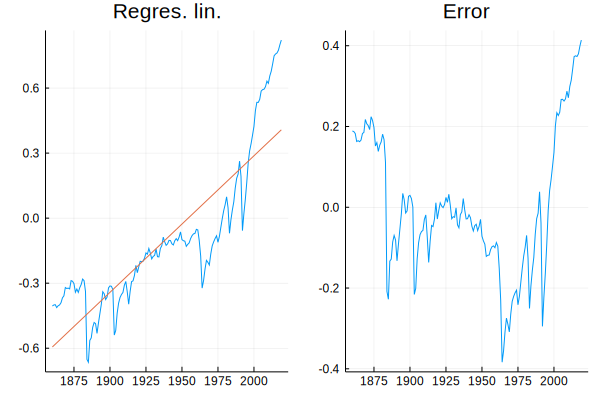

In [13]:
# Get the linear regression of GIEC temperature model over years
b, a = linreg(Dg, Tg)
regTg = a .* Dg .+ b

plot(plot(Dg, [Tg regTg], title="Regres. lin.", leg=false),
     plot(Dg, Tg .- regTg, title="Error", leg=false),
     layout=2)

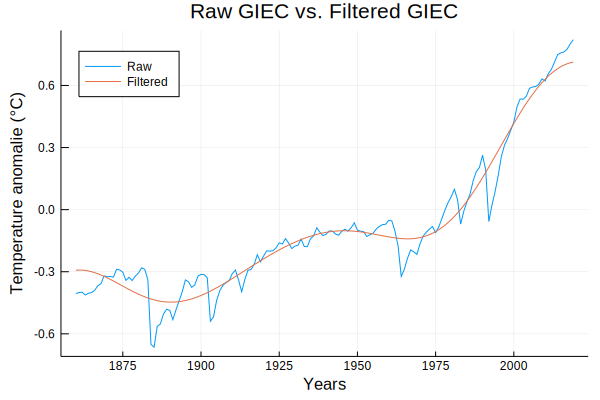

In [14]:
# Filtered GIEC model
Tgf = filtFFT(Tg .- regTg, 4) .+ regTg

plot(Dg, Tg, title="Raw GIEC vs. Filtered GIEC",
             xlabel="Years", ylabel="Temperature anomalie (°C)", 
             label="Raw", legend=:topleft)
plot!(Dg, Tgf, label="Filtered")

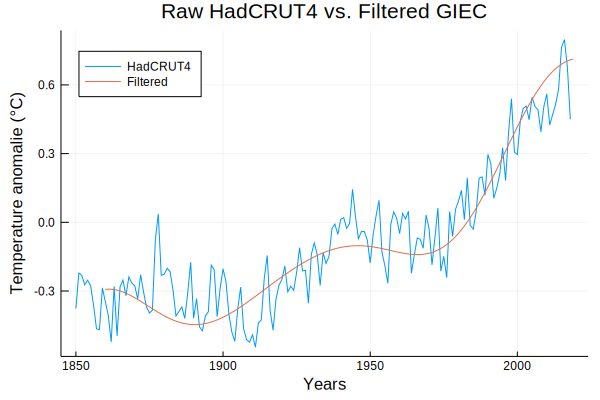

In [15]:
plot(Dh, Th, title="Raw HadCRUT4 vs. Filtered GIEC",
             xlabel="Years", ylabel="Temperature anomalie (°C)", 
             label="HadCRUT4", legend=:topleft)
plot!(Dg, Tgf, label="Filtered")

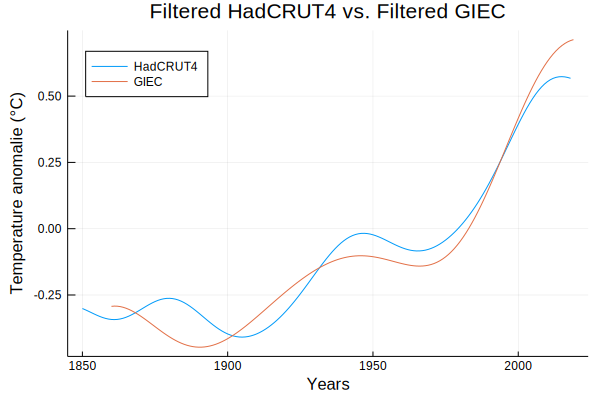

In [16]:
# Filtered GIEC model versus filtered HadCRUT4
plot(Dh, Thf, title="Filtered HadCRUT4 vs. Filtered GIEC",
              xlabel="Years", ylabel="Temperature anomalie (°C)", 
              label="HadCRUT4", legend=:topleft)

plot!(Dg, Tgf, label="GIEC")

## Error of GIEC model

Error compared to current filtered real temperature at year 2019: 27 %

In [17]:
100 * abs(Tgf[end] - Thf[end]) / Thf[end]

25.682348221463503

Estimated Temperature in 2090: 1.5°C:

In [18]:
Y, EstimTg = Int64(G[231,1]), G[231,2] - Toff

(2090, 1.4882638751861041)

GIEC model error compared to temperature HadCRUT4 based model: 18 %

In [19]:
100 * abs(EstimTg - EstimTh) / EstimTh

4.499965810840915

## Ljungqvist's Temperature Reconstruction

In [20]:
# Ljungqvist dataset:
#   1st column: temporal slice (ie 09 means from year to year 9).
#   2nd column: averaged temperature over 10 years (from year 0 to 2000).
L = convert(Matrix{Float64}, readdlm("data/ljung.txt", ' ', Any, '\n'));
Dl = convert(Vector{Int64}, [1:size(L,1);]) .* 10
Tl = L[:,2];

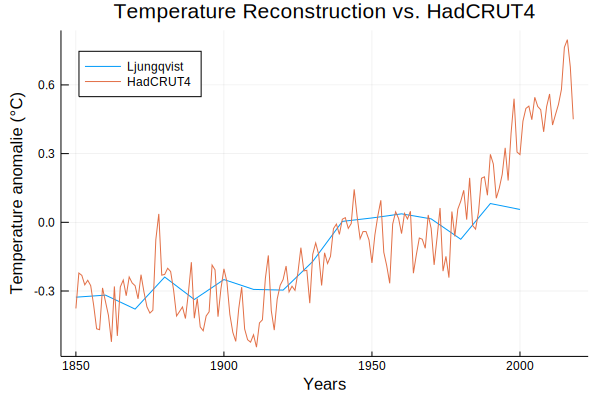

In [21]:
plot(Dl[185:end], Tl[185:end],
    title="Temperature Reconstruction vs. HadCRUT4",
    xlabel="Years", ylabel="Temperature anomalie (°C)", 
    label="Ljungqvist", legend=:topleft)

plot!(Dh, Th, label="HadCRUT4")

Complete Ljungqvist missing temperatures (year 2000 -- 2019) with HadCRUT4 values.

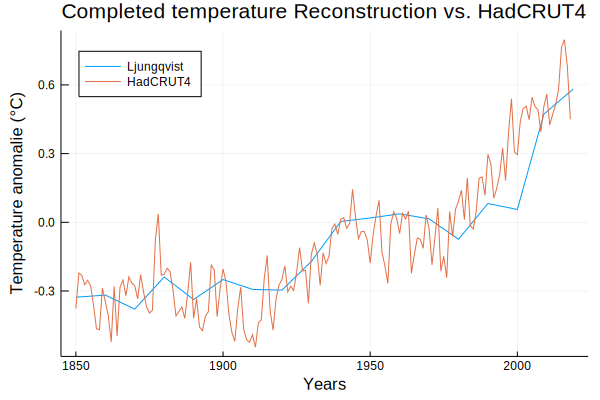

In [22]:
Dl = [Dl; 2009; 2019]
Tl = [Tl; mean(Th[yh2i(2000):yh2i(2010)]); mean(Th[yh2i(2010):yh2i(Dh[end])])]

plot(Dl[185:end], Tl[185:end],
    title="Completed temperature Reconstruction vs. HadCRUT4",
    xlabel="Years", ylabel="Temperature anomalie (°C)", 
    label="Ljungqvist", legend=:topleft)

plot!(Dh, Th, label="HadCRUT4")

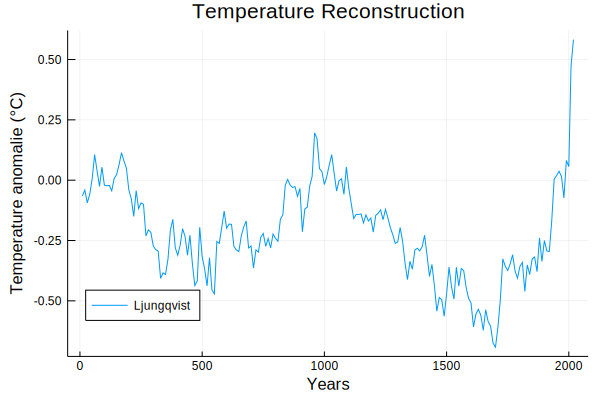

In [23]:
plot(Dl, Tl, title="Temperature Reconstruction", xlabel="Years", ylabel="Temperature anomalie (°C)", 
             label="Ljungqvist", legend=:bottomleft)

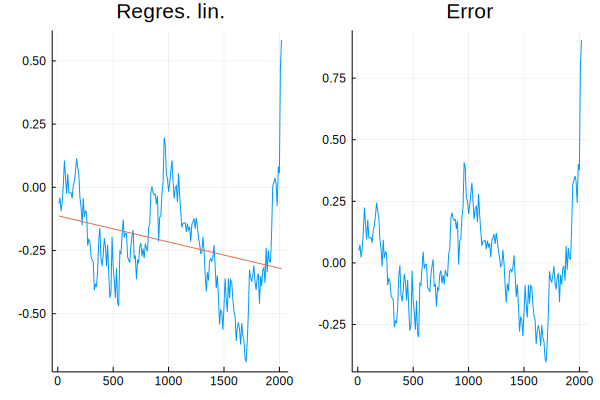

In [24]:
# Get the linear regression of Ljungqvist temperature model over years
b, a = linreg(Dl, Tl)
regTl = a .* Dl .+ b

plot(plot(Dl, [Tl regTl], title="Regres. lin.", leg=false),
     plot(Dl, Tl .- regTl, title="Error", leg=false),
     layout=2)

### 1000-year cycle

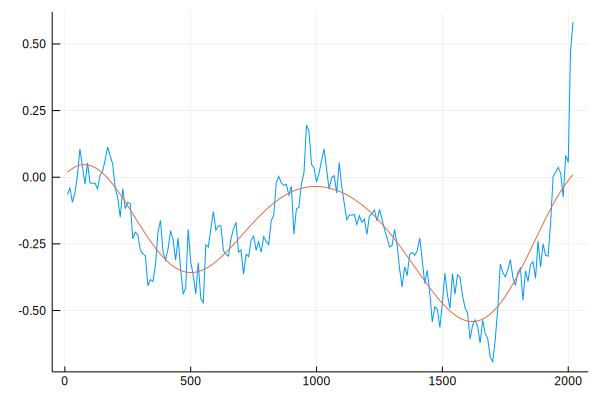

In [25]:
Tlf1000 = filtFFT(Tl, 4)
plot(Dl, [Tl Tlf1000], leg=false)

In [26]:
#F = fft(Tlf1000) |> fftshift
#Ts = 10.0 # Sample period
#freqs = fftfreq(length(F), 1.0 / Ts) |> fftshift
#plot(freqs[95:105], abs.(F)[95:105], title = "Spectrum")

### 200-year cycle

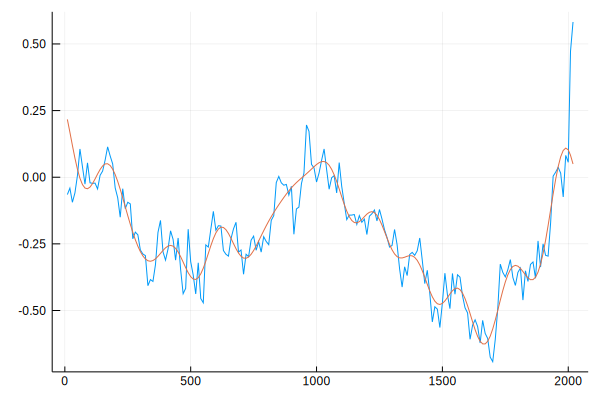

In [27]:
Tlf200 = filtFFT(Tl.- regTl, 14) .+ regTl
plot(Dl, [Tl Tlf200], leg=false)

### 60-year cycle

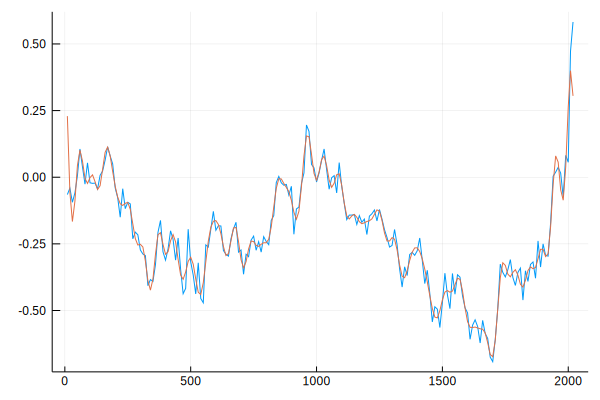

In [28]:
Tlf60 = filtFFT(Tl.- regTl, 40) .+ regTl
plot(Dl, [Tl Tlf60], leg=false)

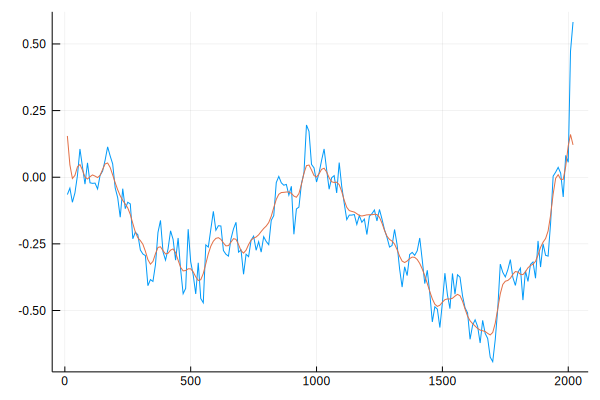

In [29]:
Q = Tlf60 .+ Tlf200 .+ Tlf1000
plot(Dl, [Tl Q ./ 3], leg=false)